# Optimizing data reductions with NDArrays

Blosc2 leverages the power of NumPy to perform efficient reductions on compressed multidimensional arrays. By compressing data with Blosc2, it is possible to reduce the memory and storage space required to store large datasets, while maintaining fast access times. This is especially beneficial for systems with memory constraints, as it allows for faster data access and manipulation.

In this tutorial, we will explore how Python-Blosc2 can perform data reductions in NDArray objects (or any other object fulfilling the `LazyArray` interface) and how the performance of these operations can be optimized by using different chunk shapes, compression levels and codecs.  We will compare the performance of Python-Blosc2 with NumPy.

**Note**: This tutorial assumes that you have Python, NumPy, matplotlib and Blosc2 installed on your system.  Also, this notebook has been run on a CPU (Intel 13900K) with a relatively large L3 cache (36 MB). As it turns out, performance in Blosc2 is very sensitive to the CPU cache size, and the results may vary on different CPUs, so your mileage may vary.

## The 3D array

We will use a 3D array of type float64 with shape (1000, 1000, 1000). This array will be filled with values from 0 to 1000, and the goal will be to compute the sum of values in stripes of 100 elements in one axis, and including all the values in the other axis. We will perform reductions along the X, Y, and Z axes, comparing Python-Blosc2 performance (with and without compression) against NumPy.

In [6]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

import blosc2

In [7]:
# Create a 3D array of type float64 (8 GB)
dtype = np.float64
shape = (1000, 1000, 1000)
size = np.prod(shape)
a = np.linspace(0, 1000, num=size, dtype=dtype).reshape(shape)

## Reducing with NumPy

We will start by performing different sum reductions using NumPy.  First, summing along the X, Y, and Z axes (and getting 2D arrays as result) and then summing along all axis (and getting a scalar as result).

In [8]:
axes = ("X", "Y", "Z", "all")
meas_np = {"sum": {}, "time": {}}
for n, axis in enumerate(axes):
    n = n if axis != "all" else None
    t0 = time()
    meas_np["sum"][axis] = np.sum(a, axis=n)
    t = time() - t0
    meas_np["time"][axis] = time() - t0

## Reducing with Blosc2

Now let's create the Blosc2 array from the NumPy array.  First, let's define the parameters for Blosc2: number of threads, compression levels, codecs, and chunk sizes. We will exercise different combinations of these parameters to evaluate the performance of Python-Blosc2 in reducing data in 3D arrays.

In [9]:
# Params for Blosc2
clevels = (0, 5)
codecs = (blosc2.Codec.LZ4, blosc2.Codec.ZSTD)

Time for creating the different arrays and performing the reductions for each combination of parameters.

In [10]:
# Create a 3D array of type float64
def measure_blosc2(chunks):
    meas = {}
    for codec in codecs:
        meas[codec] = {}
        for clevel in clevels:
            meas[codec][clevel] = {"sum": {}, "time": {}}
            cparams = blosc2.CParams(clevel=clevel, codec=codec)
            a1 = blosc2.asarray(a, chunks=chunks, cparams=cparams)
            if clevel > 0:
                print(f"cratio for {codec.name} + SHUFFLE: {a1.schunk.cratio:.1f}x")
            # Iterate on Blosc2 and NumPy arrays
            for n, axis in enumerate(axes):
                n = n if axis != "all" else None
                t0 = time()
                # Perform the sum of the stripe (defined by the slice_)
                meas[codec][clevel]["sum"][axis] = a1.sum(axis=n)
                t = time() - t0
                meas[codec][clevel]["time"][axis] = t
                # If interested, you can uncomment the following line to check the results
                # np.testing.assert_allclose(meas[codec][clevel]["sum"][axis],
                #                           meas_np["sum"][axis])
    return meas

Let's plot the results for the X, Y, and Z axes, comparing the performance of Python-Blosc2 with different configurations against NumPy.

In [11]:
def plot_meas(meas_np, meas, chunks):
    _fig, ax = plt.subplots()

    # Define the groups and bar width
    groups = meas_np["time"].keys()
    bar_width = 0.2
    indices = np.arange(len(groups))

    # Plot NumPy times
    ax.bar(indices - 1.5 * bar_width, [meas_np["time"][g] for g in groups], bar_width, label="NumPy")

    # Plot Blosc2 times
    ax.bar(
        indices - 0.5 * bar_width,
        [meas[blosc2.Codec.LZ4][0]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, no compression",
    )
    ax.bar(
        indices + 0.5 * bar_width,
        [meas[blosc2.Codec.LZ4][5]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, LZ4 + SHUFFLE",
    )
    ax.bar(
        indices + 1.5 * bar_width,
        [meas[blosc2.Codec.ZSTD][5]["time"][g] for g in groups],
        bar_width,
        label="Blosc2, ZSTD + SHUFFLE",
    )

    # Set the labels and title
    ax.set_xlabel("Axis")
    ax.set_ylabel("Time (s)")
    ax.set_title("Reduction Times")
    ax.set_xticks(indices)
    ax.set_xticklabels(groups)
    ax.legend()

    plt.tight_layout()
    plt.show()

cratio for LZ4 + SHUFFLE: 11.3x
cratio for ZSTD + SHUFFLE: 39.3x


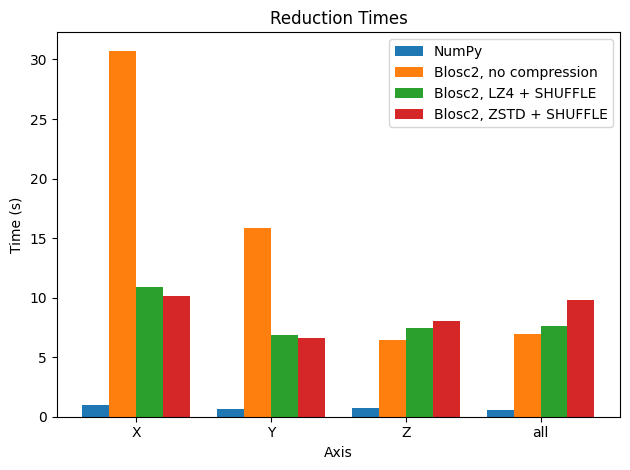

In [12]:
# Automatic chunking: (1, 1000, 1000) for Intel 13900K
chunks = None
meas = measure_blosc2(chunks)
plot_meas(meas_np, meas, chunks)

In the plot above, we can see that reductions along the X axis are much slower than those along the Y and Z axis for the Blosc2 case. This is because the automatically computed chunk shape is (1, 1000, 1000) making the overhead of partial sums larger. When reducing in all axes, Blosc2+LZ4+SHUFFLE actually achieves better performance than NumPy. See later for a discussion on these results.

Let's try to improve the performance by manually setting the chunk size. In the next case, we want to make performance similar along the three axes, so we will set the chunk size to (100, 100, 100) (8 MB).

cratio for LZ4 + SHUFFLE: 6.2x
cratio for ZSTD + SHUFFLE: 13.5x


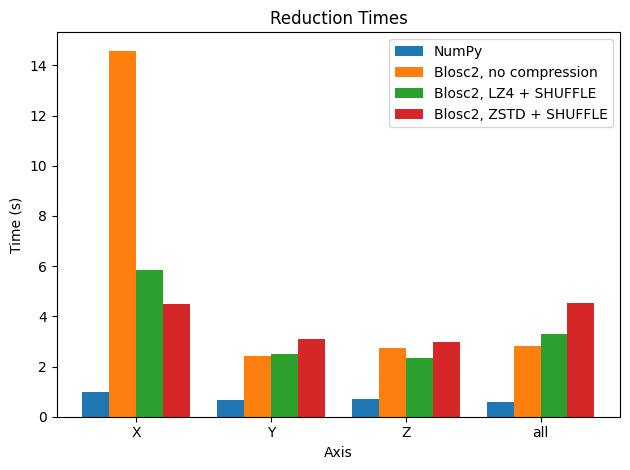

In [13]:
# Manual chunking
chunks = (100, 100, 100)
meas = measure_blosc2(chunks)
plot_meas(meas_np, meas, chunks)

In this case, performance in the X axis is already faster than Y and Z axes for Blosc2. Interestingly, performance is also faster than NumPy in X axis, while being very similar in Y and Z axis.

We could proceed further and try to fine tune the chunk size to get even better performance, but this is out of the scope of this tutorial. Instead, we will try to make some sense on the results above; see below.

## Performing reductions on 3D arrays

<div>
<img src="images/reductions/3D-cube-plane.png" width="300"/>
</div>

On a three-dimensional environment, like the one shown in the image, data is organized in a cubic space with three axes: X, Y, and Z. By default, Blosc2 chooses the chunk size so that it fits in the CPU cache. On the other hand, it tries to follow the NumPy convention of storing data row-wise; in our case above, the default chunk shape has been (1, 1000, 1000).  In this case, it is clear that reduction times along different axes are not the same, as the sizes are not uniform.
 
The difference in cost while traversing data values can be visualized more easily on a 2D array:

<div>
<img src="images/reductions/memory-access-2D-x.png" width="500"/>
</div>

Reduction along the X axis: When accessing a row (red line), the CPU can access these values (red points) from memory sequentially, but they need to be stored on an accumulator. The next rows needs to be fetched from memory and be added to the accumulator. If the size of the accumulator is large (in this case is `1000 * 1000 * 8 = 8 MB`), it does not fit in low level CPU caches, making it a slow operation.

<div>
<img src="images/reductions/memory-access-2D-y.png" width="360"/>
</div>

Reducing along the Y axis: When accessing a row (green line), the CPU can access these values (green points) from memory sequentially but, contrarily to the case above, they don't need an accumulator and the sum of the row (marked as an `*`) is final.  So, although the number of sum operations is the same as above, the required time is smaller because there is no need of updating *all* the values of the accumulator per row, but only one at a time, which is more efficient in modern CPUs.

### Tweaking the chunk size

<div>
<img src="images/reductions/3D-cube.png" width="250"/>
</div>

However, when Blosc2 is instructed to create chunks that are the same size for all the axes (`chunks=(100, 100, 100)`), the situation changes. In this case, an accumulator is needed for each subcube, but it is smaller (`100 * 100 * 8 = 80 KB`) and fits in L2, which is faster than L3 (scenario above); as the same size is used for all the axes hence the performance is similar for all of them.

It is interesting to stress out that, when using compression, performance is similar than NumPy in *all* axes, except for the X axis, where performance is up to 1.5x better. This fact is even more interesting when you know that Blosc2 is using the very same NumPy reduction machinery behind the scenes. This is a nice side effect of compression; see below.

### Effects of using different codecs in Python-Blosc2

Compression and decompression consume CPU and memory resources. Differentiating between various codecs and configurations allows for evaluating how each option impacts the use of these resources, helping to choose the most efficient option for the operating environment.

When compression is not applied, data is stored and accessed as-is; this can result in higher memory usage and longer access times, especially for large datasets. On the other hand, compression reduces the size of the data in memory and storage, which can improve performance in data reading and writing. However, compression and decompression require additional CPU time. Therefore, it is important to find the right balance between reduced size and processing time.

In the plots above, we can see how using the LZ4 codec is striking such a balance, as it achieves the best performance in general, even above a non-compressed scenario. This is because LZ4 is tuned towards speed, and the time to compress and decompress the data is very low. On the other hand, ZSTD is a codec that is optimized for compression ratio, and hence it is a bit slower.  However, it is still faster than the non-compressed case, as the reduced memory transmission compensates for the additional CPU time required for compression and decompression.

We have just scraped the surface for some of the compression parameters that can be tuned in Blosc2.  You can use the `cparams` dict with the different parameters in [blosc2.compress2()](https://www.blosc.org/python-blosc2/reference/autofiles/top_level/blosc2.compress2.html#blosc2.compress2) to set the compression level, [codec](https://www.blosc.org/python-blosc2/reference/autofiles/top_level/blosc2.Codec.html), [filters](https://www.blosc.org/python-blosc2/reference/autofiles/top_level/blosc2.Filter.html) and other parameters.  If you need a better way to tune these, there is the [Btune tool](https://ironarray.io/btune) that, depending on your requirements for how fast you want compression/decompression can go, the desired degree of compression ratio, or how similar your compressed data would be with respect to the original data (i.e. using lossy compression), can help you find the best parameters for your data and CPU by using deep learning techniques.

## Conclusion
 
Understanding the balance between space savings and the additional time required to process the data is important. Testing different compression settings can help finding the method that offers the best trade-off between reduced size and processing time. The fact that Blosc2 automatically chooses the chunk shape, makes it easy for the user to get a decently good performance, without having to worry about the details of the CPU cache.  In addition, as we have shown, we can fine tune the chunk shape in case it does not fit our needs (e.g. we need more uniform performance along all axes).

Besides the sum() reduction exercised here, Blosc2 supports a fair range of reduction operators (mean, std, min, max, all, any, etc.), and you are invited to [explore them](https://www.blosc.org/python-blosc2/reference/array_operations.html).

Finally, it is also possible to use reductions even for very large arrays that are stored on disk. This opens the door to a wide range of possibilities for data analysis and science, allowing for efficient computations on large datasets that are compressed on-disk and with minimal memory usage. We will explore this in a forthcoming tutorial.